# Objective:

Classify Amazon food reviews using Decision Trees classifier.

We'll do the following exercises in this notebook

* Load and standardize the data
        1. BoW
        2. Tfidf
        3. Avg. W2V
        4. Tfidf weighted W2V
* Divide the data in cross validation sets and find the optimal parameter using GridSearchCV.
* Gridsearch on various values of parameter max_depth.
* Plot the Cross Validation Errors 
* Plot confusion matrix and calculate Precision, Recall, FPR, TNR, FNR. 



In [0]:
# To suprress the warnings as they make the notebook less presentable.

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

Import the necessary libraries.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
import pickle
import numpy as np

This Jupyter notebook extension notifies you when a cell finishes its execution!

In [0]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

## Important parameters of Decision Trees 

* Max depth

* criterion = gini / entropy
* min_samples_leaf 
* class weight : we'll use 'balanced' for it because it is calculated as n_samples / (n_classes * np.bincount(y))

i.e. the class having more instances will get a lower weight. This is desireable since our dataset is imbalaned.

Load the target variable y of train and test sets. Note that the entire dataset is being used. All 350k reviews. The dataset is divided into train and test with ratio 80:20 respectively.

In [0]:
# f = open(r'D:\data_science\datasets\amazon2\y_train_full80_20.pkl', 'rb')
f = open('/home/ucanreachtvk/data/y_train_full80_20.pkl', 'rb')
y_train = pickle.load(f)
f.close()
print('The datatype of y_train is : {}'.format(type(y_train)))
print('The shape of y_train is : {}'.format(y_train.shape))

The datatype of y_train is : <class 'numpy.ndarray'>
The shape of y_train is : (291336,)


In [0]:
#f = open(r'D:\data_science\datasets\amazon2\y_test_full80_20.pkl', 'rb')
f = open('/home/ucanreachtvk/data/y_test_full80_20.pkl', 'rb')
y_test = pickle.load(f)
f.close()
print('The datatype of y_test is : {}'.format(type(y_test)))
print('The shape of y_test is : {}'.format(y_test.shape))

The datatype of y_test is : <class 'numpy.ndarray'>
The shape of y_test is : (72835,)


## Bag of Words

I had saved the trained BoW model and the transformed data on disk. Let's load it. 

In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_bow_full_nparray.pkl', 'rb')
X_train_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_bow is : {}'.format(type(X_train_transformed_bow)))
print('The shape of X_train_transformed_bow is : {}'.format(X_train_transformed_bow.shape))

The datatype of X_train_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_bow is : (291336, 64221)


There are 64221 features in the bow representation. Load test data too.

In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_bow_full_nparray.pkl', 'rb')
X_test_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_bow is : {}'.format(type(X_test_transformed_bow)))
print('The shape of X_test_transformed_bow is : {}'.format(X_test_transformed_bow.shape))

The datatype of X_test_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_bow is : (72835, 64221)


Count the number of non-zero elements in the array.

In [0]:
X_train_transformed_bow.count_nonzero

<bound method _data_matrix.count_nonzero of <291336x64221 sparse matrix of type '<class 'numpy.int64'>'
	with 9180635 stored elements in Compressed Sparse Row format>>

In [0]:
X_test_transformed_bow.count_nonzero

<bound method _data_matrix.count_nonzero of <72835x64221 sparse matrix of type '<class 'numpy.int64'>'
	with 2275765 stored elements in Compressed Sparse Row format>>

## Feature scaling

Decision trees don't need the data to be scaled. Because, the criteria 'gini' or 'entropy' used to generate the tree depend only on probabilities, not on distances.

## Some Functions

Let's define some functions that we'll call repeatedly in this notebook. 

1. **depth_vs_error** : For each value of depth tried in GridSearch, it will plot the error (i.e. 1 - accuracy) for train and test data. 

2. **give_me_ratios** : To plot ratios such as Precision, Recall, TNR, FPR, FNR.
3. **plot_confusion_matrix** : As the name says.
4. **GridSearch** : Create Time based cross validation splits using TimeSeriesSplit() and  create a gridsearch object for the regularization passed as a parameter. 

In [0]:
def depth_vs_error(cv_results_, x_label, y_label , title):
    
    mean_error_train = list(1 - clf.cv_results_['mean_train_score'])
    mean_error_test = list(1 - clf.cv_results_['mean_test_score'])
    
    depth = [ 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 95, 110, 133 ]
    
    df_train = pd.DataFrame({'error' : mean_error_train, 'depth':depth, 'set': ['train']*13 })
    df_test = pd.DataFrame({'error': mean_error_test, 'depth':depth, 'set': ['test']*13})
    
    df_train_test = pd.concat([df_train, df_test], keys=['error', 'depth', 'set'])
    
    plt.figure(figsize=(12,5))#.suptitle(title, fontsize=16)
    plt.subplot(1,1,1)
    sbn.barplot(data=df_train_test, x='depth', y='error', hue='set')
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel(y_label, fontsize=13)
    plt.title('{} '.format(title), fontsize=15)    
    plt.tight_layout()
    plt.show()

In [0]:
def give_me_ratios(X_train, y_train, X_test, y_test, vector_type, table, clf): 
    
    cm_train = confusion_matrix(y_train, clf.predict(X_train))
    tn, fp, fn, tp = cm_train.ravel()

    recall_train = round(tp/(tp+fn),2)
    precision_train = round(tp/(tp+fp),2)
    tnr_train = round(tn/(tn+fp),2)
    fpr_train = round(fp/(fp+tn),2)
    fnr_train = round(fn/(fn+tp),2)
    accuracy_train = round((tp+tn)/(tp+tn+fp+fn))
    accuracy_train = (tp+tn)/(tp+tn+fp+fn)

    cm_test = confusion_matrix(y_test, clf.predict(X_test))
    tn, fp, fn, tp = cm_test.ravel()
    recall_test = round(tp/(tp+fn),2)
    precision_test = round(tp/(tp+fp),2)
    tnr_test = round(tn/(tn+fp),2)
    fpr_test = round(fp/(fp+tn),2)
    fnr_test = round(fn/(fn+tp),2)
    accuracy_test = round(tp+tn)/(tp+tn+fp+fn)

    table.field_names = ['Vector Type','Data Set', 'Precision', 'Recall', 'TNR', 'FPR', 'FNR', 'Accuracy']
    table.add_row([vector_type,'Train', precision_train, recall_train, tnr_train, fpr_train, fnr_train, accuracy_train])
    table.add_row([vector_type,'Test', precision_test, recall_test, tnr_test, fpr_test, fnr_test, accuracy_test])

    print(table)
    
    return (cm_train, cm_test)

In [0]:
def plot_confusion_matrix(cm_train, cm_test, title):
    
    import pandas as pd
    plt.figure(figsize=(15,6)).suptitle(title, fontsize=15)
    
    plt.subplot(1,2,1)
    df_cm = pd.DataFrame(cm_train, range(2), range(2))
    sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Predicted Class', fontsize=15)
    plt.ylabel('Actual Class', fontsize=15)
    plt.title('Train Data', fontsize = 14)

    plt.subplot(1,2,2)    
    df_cm = pd.DataFrame(cm_test, range(2), range(2))
    sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Predicted Class', fontsize=15)
    # plt.ylabel('Actual Class', fontsize=15)

    plt.title('Test Data', fontsize = 14)

    plt.tight_layout()

In [0]:
def GridSearch(X_train):

    tscv = TimeSeriesSplit(n_splits=10)
    my_cv = tscv.split(X_train)

    dtc = DecisionTreeClassifier(class_weight = 'balanced', min_samples_split=10 , random_state=13)

    hyp_par = {
                'max_depth':[ 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 95, 110, 133]
        }

    clf = GridSearchCV(estimator=dtc, cv=my_cv, param_grid=hyp_par, n_jobs=8, return_train_score=True)
    
    return clf

### Bag of Words

Get the classifier by calling the GridSearch funtion

In [0]:
clf = GridSearch(X_train_transformed_bow)

Train the model

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_bow, y_train)

In [0]:
clf.best_params_

{'max_depth': 133}

**CV Errors | BoW**

Plot errors during cross validation using the function we defined above.

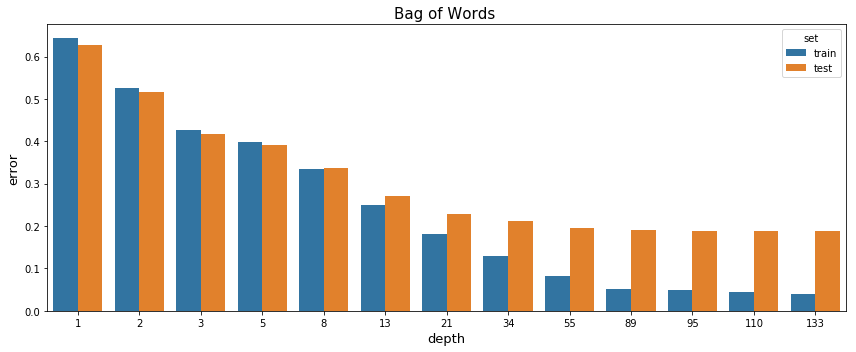

In [0]:
depth_vs_error(clf.cv_results_, 'depth', 'error', title='Bag of Words')

Import prettytable to summarize the results in a table

In [0]:
# !pip install PrettyTable
# from prettytable import PrettyTable
from prettytable import PrettyTable
table = PrettyTable()

**Ratios | BoW**

In [0]:
cm_bow_train, cm_bow_test = give_me_ratios(X_train_transformed_bow, y_train, X_test_transformed_bow, y_test, 'Bag of Words', table, clf)

+--------------+----------+-----------+--------+------+------+------+--------------------+
| Vector Type  | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+----------+-----------+--------+------+------+------+--------------------+
| Bag of Words |  Train   |    1.0    |  0.95  | 0.99 | 0.01 | 0.05 | 0.9595381277974573 |
| Bag of Words |   Test   |    0.91   |  0.86  | 0.6  | 0.4  | 0.14 | 0.8134687993409762 |
+--------------+----------+-----------+--------+------+------+------+--------------------+


**Confusion Matrix | BoW**

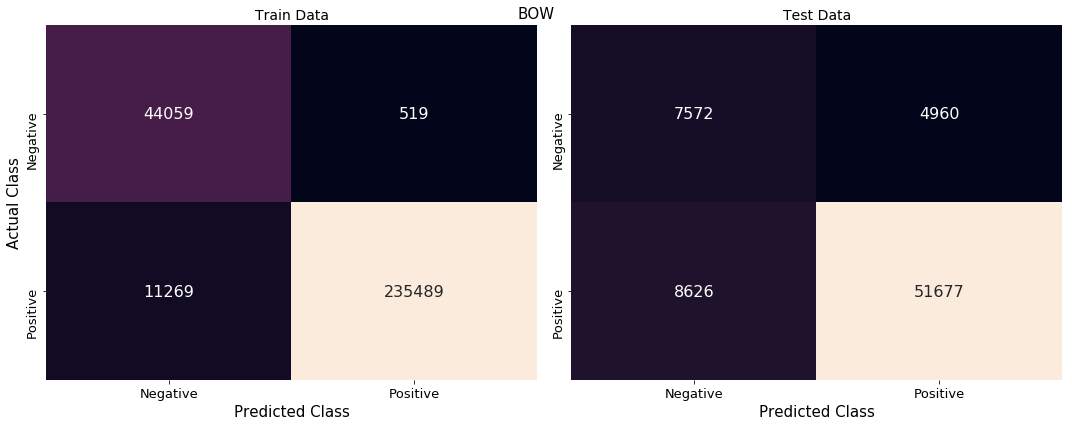

In [0]:
plot_confusion_matrix(cm_bow_train, cm_bow_test, title="BOW")

## Tfidf

In this section, we'll apply DTC on reviews represented in the Tfidf format. Load the transformed train and test sets.

In [0]:
#f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_tfidf_full_nparray.pkl', 'rb')
X_train_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_tfidf is : {}'.format(type(X_train_transformed_tfidf)))
print('The shape of X_train_transformed_tfidf is : {}'.format(X_train_transformed_tfidf.shape))

The datatype of X_train_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_tfidf is : (291336, 64221)


In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_tfidf_full_nparray.pkl', 'rb')
X_test_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_tfidf is : {}'.format(type(X_test_transformed_tfidf)))
print('The shape of X_test_transformed_tfidf is : {}'.format(X_test_transformed_tfidf.shape))

The datatype of X_test_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_tfidf is : (72835, 64221)


Get the gridsearch object

In [0]:
clf = GridSearch(X_train_transformed_tfidf)

Train the model

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_tfidf, y_train)

In [0]:
clf.best_params_

{'max_depth': 133}

**CV errors | Tfidf**

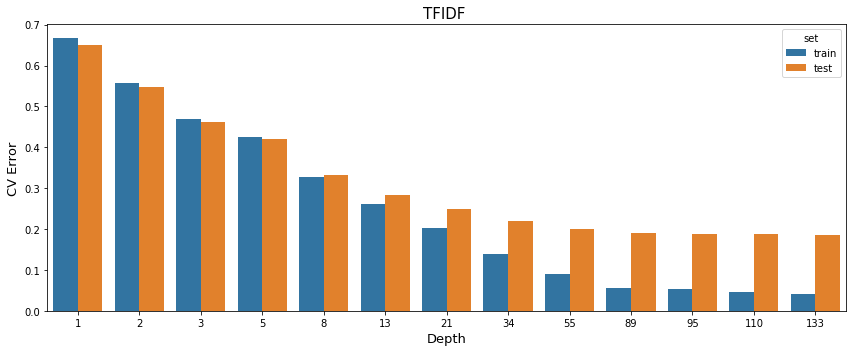

In [0]:
depth_vs_error(clf.cv_results_, 'Depth', 'CV Error', title='TFIDF')

**Ratios | Tfidf**

In [0]:
cm_tfidf_train, cm_tfidf_test = give_me_ratios(X_train_transformed_tfidf, y_train, X_test_transformed_tfidf, y_test, 'TFIDF', table, clf)

+--------------+----------+-----------+--------+------+------+------+--------------------+
| Vector Type  | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+----------+-----------+--------+------+------+------+--------------------+
| Bag of Words |  Train   |    1.0    |  0.95  | 0.99 | 0.01 | 0.05 | 0.9595381277974573 |
| Bag of Words |   Test   |    0.91   |  0.86  | 0.6  | 0.4  | 0.14 | 0.8134687993409762 |
|    TFIDF     |  Train   |    1.0    |  0.96  | 1.0  | 0.0  | 0.04 | 0.962709723480792  |
|    TFIDF     |   Test   |    0.91   |  0.86  | 0.6  | 0.4  | 0.14 | 0.8160087869842796 |
+--------------+----------+-----------+--------+------+------+------+--------------------+


**Confusion Matrix**

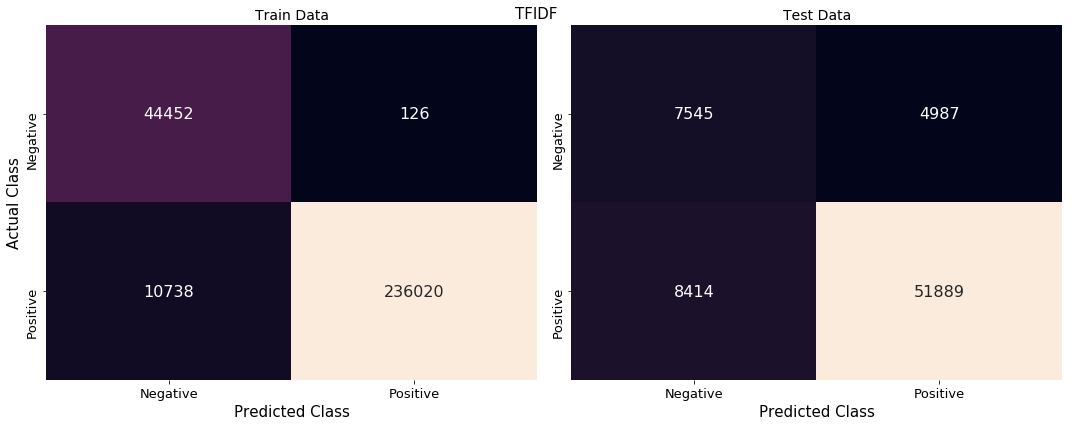

In [0]:
plot_confusion_matrix(cm_tfidf_train, cm_tfidf_test, "TFIDF")

## Avg W2V

In this section, we'll apply DTC on data represented in the avg. W2V format.
load the train and test data stored on disk.

In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_avgW2V is : {}'.format(type(X_train_transformed_avgW2V)))
print('The shape of X_train_transformed_avgW2V is : {}'.format(X_train_transformed_avgW2V.shape))

The datatype of X_train_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_avgW2V is : (291336, 50)


In [0]:
#f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_avgW2V is : {}'.format(type(X_test_transformed_avgW2V)))
print('The shape of X_test_transformed_avgW2V is : {}'.format(X_test_transformed_avgW2V.shape))

The datatype of X_test_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_test_transformed_avgW2V is : (72835, 50)


Get the gridsearch object

In [0]:
clf = GridSearch(X_train_transformed_avgW2V)

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_avgW2V, y_train)

CPU times: user 31.7 s, sys: 312 ms, total: 32 s
Wall time: 4min 51s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f82a1674d58>,
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'max_depth': [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 95, 110, 133]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

In [0]:
clf.best_params_

{'max_depth': 55}

**CV Errors | Avg. W2V**

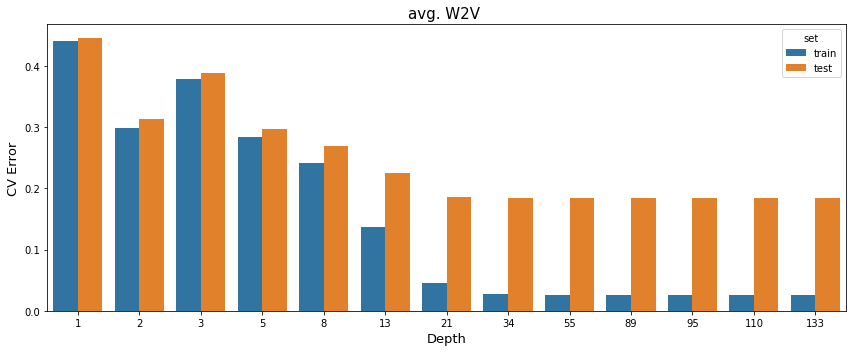

In [0]:
depth_vs_error(clf.cv_results_, 'Depth', 'CV Error', title='avg. W2V')

**Ratios**

In [0]:
cm_w2v_train, cm_w2v_test = give_me_ratios(X_train_transformed_avgW2V, y_train, X_test_transformed_avgW2V, y_test, 'avg. W2V', table, clf)

+--------------+----------+-----------+--------+------+------+------+--------------------+
| Vector Type  | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+----------+-----------+--------+------+------+------+--------------------+
| Bag of Words |  Train   |    1.0    |  0.95  | 0.99 | 0.01 | 0.05 | 0.9595381277974573 |
| Bag of Words |   Test   |    0.91   |  0.86  | 0.6  | 0.4  | 0.14 | 0.8134687993409762 |
|    TFIDF     |  Train   |    1.0    |  0.96  | 1.0  | 0.0  | 0.04 | 0.962709723480792  |
|    TFIDF     |   Test   |    0.91   |  0.86  | 0.6  | 0.4  | 0.14 | 0.8160087869842796 |
|   avg. W2V   |  Train   |    1.0    |  0.97  | 1.0  | 0.0  | 0.03 | 0.9737725512809952 |
|   avg. W2V   |   Test   |    0.89   |  0.88  | 0.49 | 0.51 | 0.12 | 0.8111896752934715 |
+--------------+----------+-----------+--------+------+------+------+--------------------+


**Confusion Matrix**

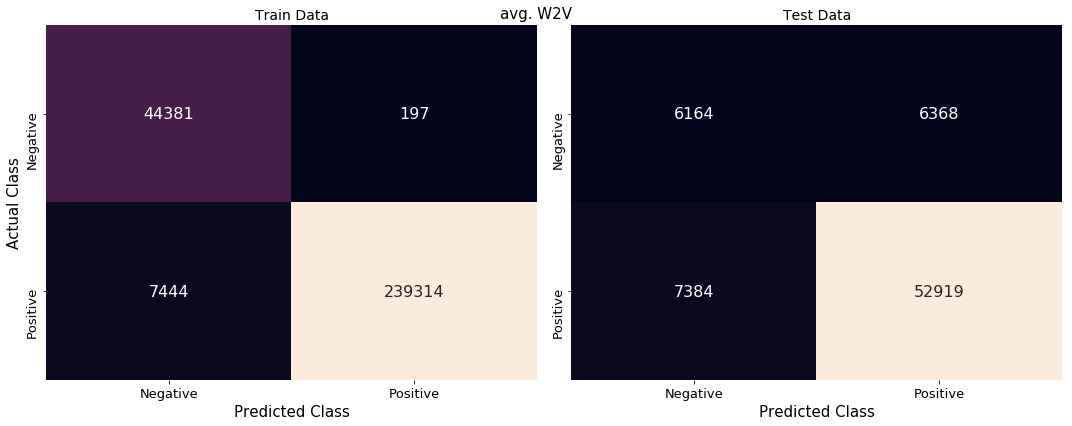

In [0]:
plot_confusion_matrix(cm_w2v_train, cm_w2v_test, "avg. W2V")

## Tfidf weighted W2V

In this last section, we apply DTC on vectors represented in the form of Tfidf weighted W2V.

In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_TfidfW2V is : {}'.format(type(X_train_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_train_transformed_TfidfW2V.shape))

The datatype of X_train_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (291336, 50)


In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_TfidfW2V is : {}'.format(type(X_test_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_test_transformed_TfidfW2V.shape))

The datatype of X_test_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (72835, 50)


Get gridseach object

In [0]:
clf = GridSearch(X_train_transformed_TfidfW2V)

In [0]:
%%notify
%%time

clf.fit(X_train_transformed_TfidfW2V, y_train)

CPU times: user 34.2 s, sys: 132 ms, total: 34.3 s
Wall time: 5min 1s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f82a3c688e0>,
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'max_depth': [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 95, 110, 133]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

In [0]:
clf.best_params_

{'max_depth': 34}

**CV Errors | Tfidf wt. W2V**

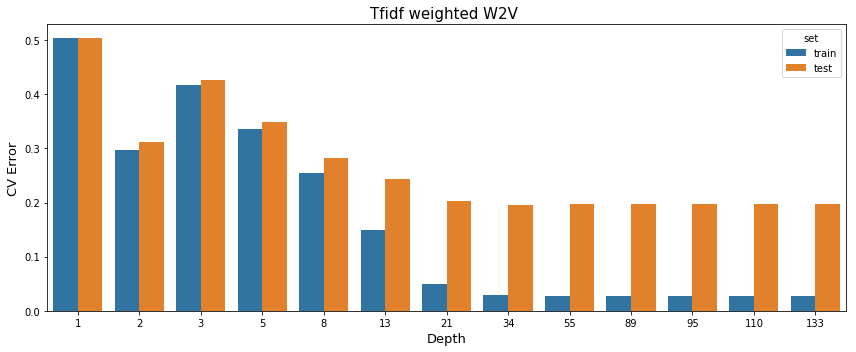

In [0]:
depth_vs_error(clf.cv_results_, 'Depth', 'CV Error', title='Tfidf weighted W2V')

**Ratios | Tfidf wt. W2V**

In [0]:
cm_tfidfw2v_train, cm_tfidfw2v_test = give_me_ratios(X_train_transformed_TfidfW2V, y_train, X_test_transformed_TfidfW2V, y_test, 'Tfidf weighted W2V', table, clf)

+--------------------+----------+-----------+--------+------+------+------+--------------------+
|    Vector Type     | Data Set | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------------+----------+-----------+--------+------+------+------+--------------------+
|    Bag of Words    |  Train   |    1.0    |  0.95  | 0.99 | 0.01 | 0.05 | 0.9595381277974573 |
|    Bag of Words    |   Test   |    0.91   |  0.86  | 0.6  | 0.4  | 0.14 | 0.8134687993409762 |
|       TFIDF        |  Train   |    1.0    |  0.96  | 1.0  | 0.0  | 0.04 | 0.962709723480792  |
|       TFIDF        |   Test   |    0.91   |  0.86  | 0.6  | 0.4  | 0.14 | 0.8160087869842796 |
|      avg. W2V      |  Train   |    1.0    |  0.97  | 1.0  | 0.0  | 0.03 | 0.9737725512809952 |
|      avg. W2V      |   Test   |    0.89   |  0.88  | 0.49 | 0.51 | 0.12 | 0.8111896752934715 |
| Tfidf weighted W2V |  Train   |    1.0    |  0.96  | 1.0  | 0.0  | 0.04 | 0.9689911305159679 |
| Tfidf weighted W2V |   Test 

**Confusion Matrix | Tfidf wt. W2V**

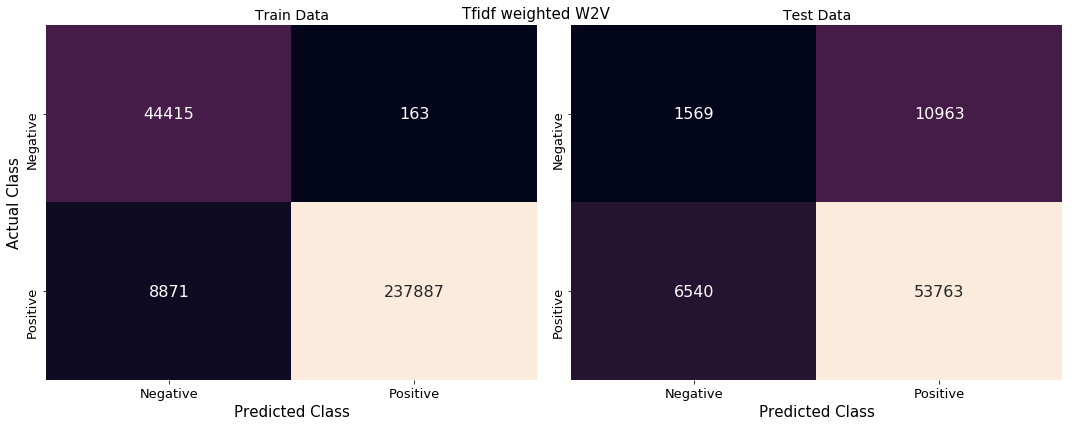

In [0]:
plot_confusion_matrix(cm_tfidfw2v_train, cm_tfidfw2v_test, "Tfidf weighted W2V")

### Conclusion:

* We applied Decision Tree classifier on amazon food reviews for various vector representations.

* The choice of parameter 'max_depth' is crucial to the performance of the model. When depth is too low, the model underfits. When it's too much, it overfits.
